# K-Means Clustering per Versi Aplikasi

Notebook ini membantu mengelompokkan ulasan Tokopedia berdasarkan versi aplikasi sehingga masalah utama tiap versi lebih mudah dipahami.

Alur utama:
1. Muat dataset hasil analisis (`df_analist_exported.csv`).
2. Pilih kolom teks dan kolom versi aplikasi yang ingin dianalisis.
3. (Opsional) Filter ke versi tertentu sebelum pemodelan.
4. Representasikan teks dengan TF-IDF + reduksi SVD.
5. Gunakan kombinasi metode elbow dan silhouette untuk memilih jumlah cluster.
6. Latih model final dan ringkas temuan per cluster serta per versi.

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.decomposition import TruncatedSVD
from collections import Counter

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

RANDOM_STATE = 42
DATA_PATH = Path("../2_preprocessing/df_analist_exported.csv")
TEXT_COLUMN = "content"  # ubah ke kolom teks lain bila diperlukan
VERSION_COLUMN = "appVersion"          # fallback otomatis ke reviewCreatedVersion bila kolom ini tidak ada


In [24]:
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape (raw): {df.shape}")

if TEXT_COLUMN not in df.columns:
    raise KeyError(f"Kolom teks '{TEXT_COLUMN}' tidak ditemukan. Periksa kembali nama kolom yang ingin dipakai.")

def _resolve_version_column(df, preferred, fallback="reviewCreatedVersion"):
    if preferred in df.columns:
        return preferred
    if fallback in df.columns:
        print(f"Kolom version '{preferred}' tidak tersedia. Menggunakan '{fallback}' sebagai gantinya.")
        return fallback
    raise KeyError("Kolom versi aplikasi tidak ditemukan. Pastikan salah satu dari 'appVersion' atau 'reviewCreatedVersion' tersedia.")

VERSION_COLUMN = _resolve_version_column(df, VERSION_COLUMN)


def _clean_text(series):
    cleaned = series.dropna().astype(str).str.strip()
    cleaned = cleaned[cleaned.str.len() > 0]
    return cleaned

df = df.dropna(subset=[TEXT_COLUMN]).copy()
df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str).str.strip()
df = df[df[TEXT_COLUMN].str.len() > 0].reset_index(drop=True)

# jaga kolom versi tetap string yang terisi
_df_version = df[VERSION_COLUMN].fillna("Unknown").astype(str).str.strip()
_df_version = _df_version.replace("", "Unknown")
df[VERSION_COLUMN] = _df_version

print(f"Dataset shape (bersih): {df.shape}")

cols_to_show = [TEXT_COLUMN, VERSION_COLUMN]
for extra_col in ["Labelling", "score"]:
    if extra_col in df.columns and extra_col not in cols_to_show:
        cols_to_show.append(extra_col)

display(df[cols_to_show].head())


Dataset shape (raw): (41886, 26)
Dataset shape (bersih): (41886, 26)


,content,appVersion,score
0,Banyak penjual barang yang menjual tidak sesua...,Unknown,1
1,Gk jelas tiba² pembatalan pesanan katanya tida...,3.251,1
2,. Expedisi nya ga jelas.. Kirim paket aja smpa...,3.251,1
3,Parah beli barang malah di tuduh manipulasi da...,3.250,1
4,terimakasih ok bangat,3.250,5


## Pemeriksaan Panjang `stemmed_text`
Gunakan sel ini untuk mengetahui berapa banyak baris yang memiliki kata lebih dari satu dan berapa yang hanya satu kata pada kolom `stemmed_text`.

In [25]:
if 'stemmed_text' not in df.columns:
    raise KeyError("Kolom 'stemmed_text' tidak ditemukan di dataframe. Pastikan nama kolom sudah benar.")

stem_series = df['stemmed_text'].fillna('').astype(str).str.strip()
stem_lengths = stem_series.apply(lambda text: len([token for token in text.split() if token]))

count_multiple = (stem_lengths > 1).sum()
count_single = (stem_lengths == 1).sum()
count_zero = (stem_lengths == 0).sum()

total_rows = len(stem_series)
summary = pd.DataFrame(
    {
        'kategori': ['> 1 kata', '= 1 kata', '= 0 kata'],
        'jumlah': [count_multiple, count_single, count_zero]
    }
)
summary['persentase'] = (summary['jumlah'] / total_rows * 100).round(2)

print(f"Total baris dianalisis: {total_rows}")
print(f"> 1 kata : {count_multiple}")
print(f"= 1 kata : {count_single}")
print(f"= 0 kata : {count_zero}")

display(summary)


Total baris dianalisis: 41886
> 1 kata : 32304
= 1 kata : 8424
= 0 kata : 1158


,kategori,jumlah,persentase
0,> 1 kata,32304,77.12
1,= 1 kata,8424,20.11
2,= 0 kata,1158,2.76


In [26]:
version_counts = (
    df[VERSION_COLUMN]
    .value_counts()
    .to_frame(name="review_count")
)

print("Top 10 versi aplikasi berdasarkan jumlah ulasan:")
display(version_counts.head(10))


Top 10 versi aplikasi berdasarkan jumlah ulasan:


,review_count
appVersion,
Unknown,7788
3.247.1,2380
3.215,1298
3.246,1089
3.202,1060
3.242,872
3.249,763
3.226,647
3.217,573


## Pilih Versi yang Akan Diclustering
Atur `TARGET_VERSION` menjadi salah satu nilai pada tabel di atas (string tunggal atau daftar).
Jika `TARGET_VERSION = None`, seluruh versi akan digabung dan diklaster secara bersamaan.

In [27]:
TARGET_VERSION = None              # contoh: "9.39.3" atau ["9.39.3", "9.39.4"]
MIN_REVIEWS_PER_VERSION = 200      # minimum ulasan agar hasil cluster tetap stabil

if TARGET_VERSION is None:
    selected_versions = None
else:
    if isinstance(TARGET_VERSION, str):
        selected_versions = [TARGET_VERSION]
    else:
        selected_versions = list(TARGET_VERSION)

if selected_versions:
    working_df = df[df[VERSION_COLUMN].isin(selected_versions)].copy()
    missing_versions = [v for v in selected_versions if v not in df[VERSION_COLUMN].unique()]
    if missing_versions:
        raise ValueError(f"Versi berikut tidak ditemukan di dataset: {missing_versions}")
else:
    working_df = df.copy()

if selected_versions and len(working_df) < MIN_REVIEWS_PER_VERSION:
    raise ValueError(
        f"Jumlah ulasan untuk versi {selected_versions} hanya {len(working_df)} (< {MIN_REVIEWS_PER_VERSION}). Turunkan MIN_REVIEWS_PER_VERSION atau pilih versi lain."
    )

selected_label = ", ".join(selected_versions) if selected_versions else "Semua versi"
print(f"Total ulasan yang dianalisis: {len(working_df)} (Versi: {selected_label})")

display(working_df[[VERSION_COLUMN, TEXT_COLUMN]].head())


Total ulasan yang dianalisis: 41886 (Versi: Semua versi)


,appVersion,content
0,Unknown,Banyak penjual barang yang menjual tidak sesua...
1,3.251,Gk jelas tiba² pembatalan pesanan katanya tida...
2,3.251,. Expedisi nya ga jelas.. Kirim paket aja smpa...
3,3.250,Parah beli barang malah di tuduh manipulasi da...
4,3.250,terimakasih ok bangat


In [28]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    max_features=5000,
    ngram_range=(1, 2),
    sublinear_tf=True
)

tfidf_matrix = vectorizer.fit_transform(working_df[TEXT_COLUMN])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


TF-IDF matrix shape: (41886, 5000)


In [29]:
N_COMPONENTS = 50
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
reduced_features = svd.fit_transform(tfidf_matrix)
explained_var = svd.explained_variance_ratio_.sum()

print(f"Reduced shape: {reduced_features.shape}")
print(f"Total explained variance: {explained_var:.2%}")


Reduced shape: (41886, 50)
Total explained variance: 26.28%


k= 2 | inertia=9,101 | silhouette=0.4661
k= 3 | inertia=8,123 | silhouette=0.4928
k= 4 | inertia=7,266 | silhouette=0.5110
k= 5 | inertia=6,561 | silhouette=0.5137
k= 6 | inertia=6,227 | silhouette=0.4618
k= 7 | inertia=5,969 | silhouette=0.4702
k= 8 | inertia=5,708 | silhouette=0.4780
k= 9 | inertia=5,466 | silhouette=0.4857
k=10 | inertia=5,452 | silhouette=0.1436


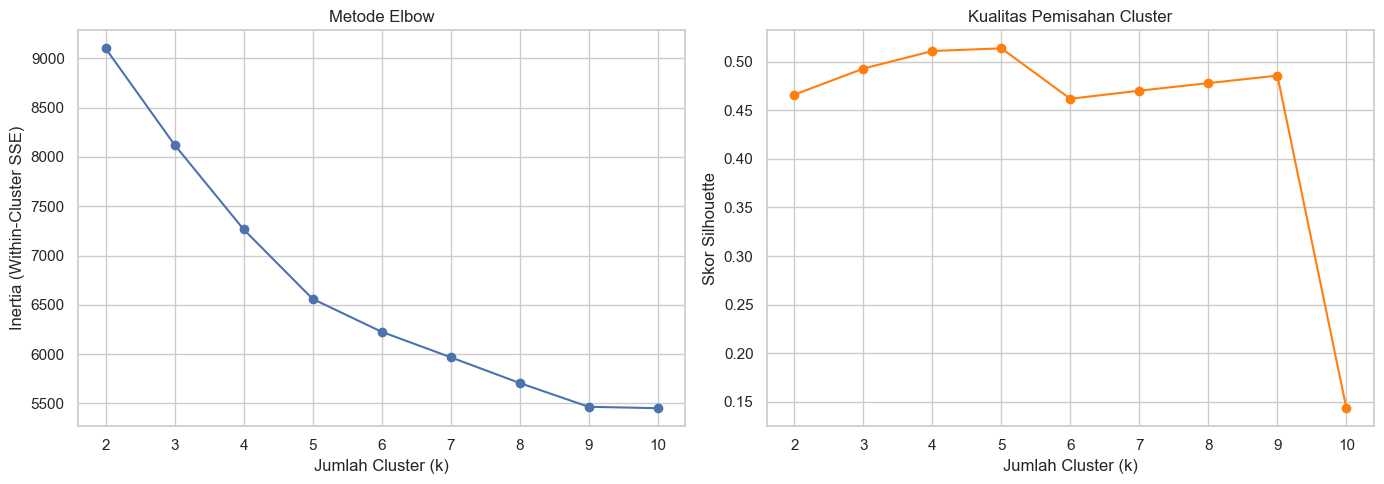

In [30]:
k_range = range(2, 11)
inertias = []
silhouettes = []

for k in k_range:
    model = KMeans(
        n_clusters=k,
        n_init=20,
        max_iter=500,
        init="k-means++",
        random_state=RANDOM_STATE
    )
    model.fit(reduced_features)
    inertias.append(model.inertia_)
    sil_score = silhouette_score(reduced_features, model.labels_)
    silhouettes.append(sil_score)
    print(f"k={k:2d} | inertia={model.inertia_:,.0f} | silhouette={sil_score:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(list(k_range), inertias, marker="o")
ax[0].set_xlabel("Jumlah Cluster (k)")
ax[0].set_ylabel("Inertia (Within-Cluster SSE)")
ax[0].set_title("Metode Elbow")

ax[1].plot(list(k_range), silhouettes, marker="o", color="tab:orange")
ax[1].set_xlabel("Jumlah Cluster (k)")
ax[1].set_ylabel("Skor Silhouette")
ax[1].set_title("Kualitas Pemisahan Cluster")

plt.tight_layout()
plt.show()


In [31]:
best_k = max(zip(k_range, silhouettes), key=lambda item: item[1])[0]
print(f"Jumlah cluster terpilih (berdasarkan skor silhouette): {best_k}")

final_model = KMeans(
    n_clusters=best_k,
    n_init=30,
    max_iter=500,
    init="k-means++",
    random_state=RANDOM_STATE
)

cluster_labels = final_model.fit_predict(reduced_features)
working_df = working_df.reset_index(drop=True)
working_df["cluster"] = cluster_labels

cluster_summary = working_df["cluster"].value_counts().sort_index()
print("Distribusi data per cluster:")
display(cluster_summary.to_frame(name="jumlah"))

for cluster_id, subset in working_df.groupby("cluster"):
    print(f"Contoh ulasan dari cluster {cluster_id} (Versi: {selected_label}):")
    display(subset[[VERSION_COLUMN, TEXT_COLUMN]].head(3))


Jumlah cluster terpilih (berdasarkan skor silhouette): 5
Distribusi data per cluster:


,jumlah
cluster,
0,37309
1,981
2,1487
3,998
4,1111


Contoh ulasan dari cluster 0 (Versi: Semua versi):


,appVersion,content
0,Unknown,Banyak penjual barang yang menjual tidak sesua...
1,3.251,Gk jelas tiba² pembatalan pesanan katanya tida...
2,3.251,. Expedisi nya ga jelas.. Kirim paket aja smpa...


Contoh ulasan dari cluster 1 (Versi: Semua versi):


,appVersion,content
26,3.250,good
64,3.247.1,GOOD TOKPED
87,3.243,Good


Contoh ulasan dari cluster 2 (Versi: Semua versi):


,appVersion,content
20,3.247.1,mantap
28,3.245,mantap
72,3.249,mantap


Contoh ulasan dari cluster 3 (Versi: Semua versi):


,appVersion,content
44,3.251,Bagus
53,3.232,bagus
70,Unknown,Bagus


Contoh ulasan dari cluster 4 (Versi: Semua versi):


,appVersion,content
4,3.250,terimakasih ok bangat
24,3.250,Ok punya
36,3.238.1,ok


In [32]:
terms = np.array(vectorizer.get_feature_names_out())

def top_terms_per_cluster(tfidf_matrix, labels, terms, top_n=15):
    records = []
    for cluster_id in np.unique(labels):
        row_ids = np.where(labels == cluster_id)[0]
        cluster_tfidf = tfidf_matrix[row_ids]
        mean_scores = cluster_tfidf.mean(axis=0).A1
        top_indices = mean_scores.argsort()[::-1][:top_n]
        for rank, term_idx in enumerate(top_indices, start=1):
            records.append(
                {
                    "cluster": cluster_id,
                    "rank": rank,
                    "term": terms[term_idx],
                    "score": mean_scores[term_idx]
                }
            )
    return pd.DataFrame(records)

cluster_terms = top_terms_per_cluster(tfidf_matrix, cluster_labels, terms, top_n=12)
print("Top fitur TF-IDF untuk masing-masing cluster:")
display(cluster_terms.groupby("cluster").head(12))


Top fitur TF-IDF untuk masing-masing cluster:


,cluster,rank,term,score
0,0,1,di,0.023417
1,0,2,tokopedia,0.021727
2,0,3,sangat,0.018936
3,0,4,dan,0.018598
4,0,5,tidak,0.017348
5,0,6,bisa,0.017305
6,0,7,aplikasi,0.016517
7,0,8,saya,0.015805
8,0,9,ada,0.015040
9,0,10,nya,0.014851


In [33]:
cluster_version_summary = (
    working_df.groupby([VERSION_COLUMN, "cluster"]).size().reset_index(name="review_count")
)
cluster_version_summary = cluster_version_summary.sort_values(["cluster", "review_count"], ascending=[True, False])
print("Ringkasan distribusi cluster per versi (berguna bila memilih beberapa versi sekaligus):")
display(cluster_version_summary)


Ringkasan distribusi cluster per versi (berguna bila memilih beberapa versi sekaligus):


,appVersion,cluster,review_count
899,Unknown,0,6962
491,3.247.1,0,2095
334,3.215,0,1070
268,3.202,0,998
486,3.246,0,970
...,...,...,...
849,3.69,4,1
872,3.82,4,1
877,3.85,4,1
879,3.86,4,1


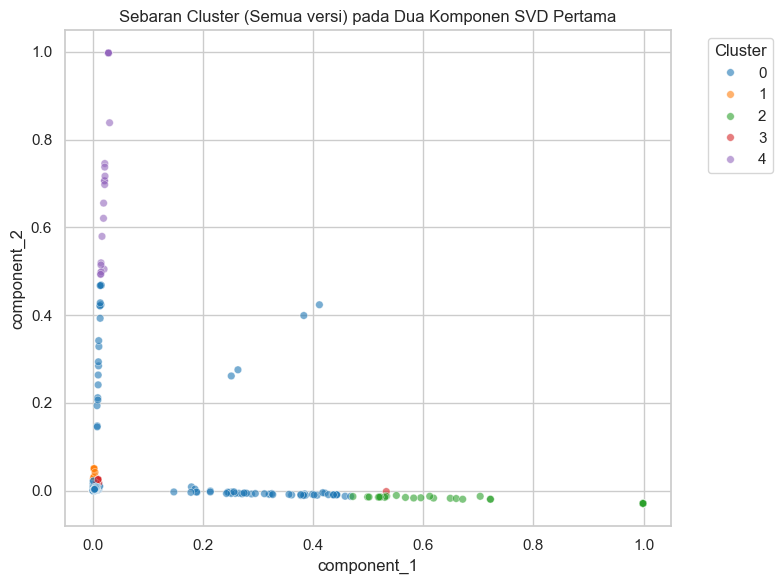

In [34]:
plot_df = pd.DataFrame(
    reduced_features[:, :2],
    columns=["component_1", "component_2"]
)
plot_df["cluster"] = cluster_labels

max_points = 4000
if len(plot_df) > max_points:
    plot_sample = plot_df.sample(max_points, random_state=RANDOM_STATE)
else:
    plot_sample = plot_df

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_sample,
    x="component_1",
    y="component_2",
    hue="cluster",
    palette="tab10",
    alpha=0.6,
    s=30
)
plt.title(f"Sebaran Cluster ({selected_label}) pada Dua Komponen SVD Pertama")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Langkah Lanjutan
- Jalankan notebook berulang dengan mengganti `TARGET_VERSION` untuk membandingkan issue tiap versi aplikasi.
- Simpan hasil cluster (misal `working_df[[VERSION_COLUMN, TEXT_COLUMN, 'cluster']]`) ke CSV agar mudah diteruskan ke tim produk.
- Eksplor metode representasi teks lain (Sentence-BERT, FastText) atau algoritma clustering berbeda (MiniBatchKMeans, HDBSCAN) bila ukuran data semakin besar.

## Matriks Evaluasi Validitas Cluster

In [35]:
overall_silhouette = silhouette_score(reduced_features, cluster_labels)
calinski = calinski_harabasz_score(reduced_features, cluster_labels)
davies = davies_bouldin_score(reduced_features, cluster_labels)
inertia = final_model.inertia_

print("Ringkasan metrik global:")
overall_metrics = pd.DataFrame(
    {
        "metric": ["silhouette", "calinski_harabasz", "davies_bouldin", "inertia"],
        "value": [overall_silhouette, calinski, davies, inertia],
    }
)
display(overall_metrics)

sample_silhouette = silhouette_samples(reduced_features, cluster_labels)

cluster_eval = (
    working_df.assign(silhouette=sample_silhouette)
    .groupby("cluster")
    .agg(
        review_count=("cluster", "size"),
        mean_silhouette=("silhouette", "mean"),
        median_silhouette=("silhouette", "median"),
        min_silhouette=("silhouette", "min"),
        max_silhouette=("silhouette", "max"),
    )
    .sort_index()
)
cluster_eval["pct_of_subset"] = (cluster_eval["review_count"] / len(working_df)) * 100
cluster_eval = cluster_eval[
    [
        "review_count",
        "pct_of_subset",
        "mean_silhouette",
        "median_silhouette",
        "min_silhouette",
        "max_silhouette",
    ]
]
cluster_eval["pct_of_subset"] = cluster_eval["pct_of_subset"].round(2)

print("Matriks evaluasi per cluster:")
display(cluster_eval)

print("Catatan: nilai silhouette berkisar antara -1 (tumpang tindih) hingga 1 (terpisah baik).")


Ringkasan metrik global:


,metric,value
0,silhouette,0.513734
1,calinski_harabasz,6124.139485
2,davies_bouldin,0.601269
3,inertia,6560.819688


Matriks evaluasi per cluster:


,review_count,pct_of_subset,mean_silhouette,median_silhouette,min_silhouette,max_silhouette
cluster,,,,,,
0,37309,89.07,0.479397,0.516943,-0.153817,0.619439
1,981,2.34,0.856150,0.933950,0.063432,0.933950
2,1487,3.55,0.845821,0.928459,0.080599,0.928459
3,998,2.38,0.604621,0.791673,-0.053091,0.791673
4,1111,2.65,0.838365,0.925839,-0.007614,0.925839


Catatan: nilai silhouette berkisar antara -1 (tumpang tindih) hingga 1 (terpisah baik).


## Re-clustering Cluster Dominan
Gunakan blok berikut untuk menjalankan K-Means ulang hanya pada salah satu cluster besar (misalnya cluster 0) agar isu-isu yang tadinya bercampur dapat dipecah lagi menjadi sub-topik yang lebih spesifik.

In [36]:
CLUSTER_TO_RECLUSTER = 0
RECLUSTER_K_RANGE = range(2, 9)          # rentang kandidat jumlah sub-cluster
RECLUSTER_MAX_FEATURES = 4000
RECLUSTER_N_COMPONENTS = 40

if "cluster" not in working_df.columns:
    raise ValueError("Jalankan proses clustering utama terlebih dahulu agar kolom 'cluster' tersedia.")

subset_df = working_df[working_df["cluster"] == CLUSTER_TO_RECLUSTER].copy()
if subset_df.empty:
    raise ValueError(f"Tidak ada data dengan cluster {CLUSTER_TO_RECLUSTER}. Pilih cluster lain.")

subset_ratio = len(subset_df) / len(working_df)
print(f"Total baris pada cluster {CLUSTER_TO_RECLUSTER}: {len(subset_df)} ({subset_ratio:.2%} dari data terpilih)")

valid_k_range = [k for k in RECLUSTER_K_RANGE if k < len(subset_df)]
if len(subset_df) <= 1 or not valid_k_range:
    raise ValueError("Jumlah data di cluster ini terlalu sedikit untuk dilakukan clustering ulang. Perlu minimal > 1 data dan rentang k yang valid.")

min_df_value = 5 if len(subset_df) > 500 else 2
vectorizer_sub = TfidfVectorizer(
    max_df=0.6,
    min_df=min_df_value,
    max_features=RECLUSTER_MAX_FEATURES,
    ngram_range=(1, 2),
    sublinear_tf=True
)

tfidf_sub = vectorizer_sub.fit_transform(subset_df[TEXT_COLUMN])
print(f"Sub TF-IDF shape: {tfidf_sub.shape}")

max_possible_components = min(tfidf_sub.shape[1] - 1, tfidf_sub.shape[0] - 1)
if max_possible_components < 2:
    raise ValueError("Tidak cukup variasi fitur untuk menjalankan SVD (butuh minimal 2 komponen). Pertimbangkan menurunkan min_df atau menggunakan rentang k berbeda.")

n_components = min(RECLUSTER_N_COMPONENTS, max_possible_components)
svd_sub = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
reduced_sub = svd_sub.fit_transform(tfidf_sub)
print(f"Sub reduced shape: {reduced_sub.shape}")

local_inertias = []
local_silhouettes = []

for k in valid_k_range:
    model = KMeans(
        n_clusters=k,
        n_init=30,
        max_iter=500,
        init="k-means++",
        random_state=RANDOM_STATE
    )
    labels = model.fit_predict(reduced_sub)
    inertia = model.inertia_
    sil = silhouette_score(reduced_sub, labels)
    local_inertias.append(inertia)
    local_silhouettes.append(sil)
    print(f"k={k:2d} | inertia={inertia:,.0f} | silhouette={sil:.4f}")

best_local_k = max(zip(valid_k_range, local_silhouettes), key=lambda item: item[1])[0]
print(f"Jumlah sub-cluster terbaik untuk cluster {CLUSTER_TO_RECLUSTER}: {best_local_k}")

recluster_model = KMeans(
    n_clusters=best_local_k,
    n_init=30,
    max_iter=500,
    init="k-means++",
    random_state=RANDOM_STATE
)

sub_labels = recluster_model.fit_predict(reduced_sub)
subset_df = subset_df.reset_index(drop=True)
subset_df["subcluster"] = sub_labels

print("Distribusi sub-cluster:")
sub_summary = subset_df["subcluster"].value_counts().sort_index()
display(sub_summary.to_frame(name="jumlah"))

print("Contoh ulasan per sub-cluster:")
for sub_id, sample in subset_df.groupby("subcluster"):
    display(sample[[VERSION_COLUMN, TEXT_COLUMN]].head(3))

sub_terms = top_terms_per_cluster(
    tfidf_sub,
    sub_labels,
    vectorizer_sub.get_feature_names_out(),
    top_n=12
)
print("Top fitur TF-IDF per sub-cluster:")
display(sub_terms.groupby("cluster").head(12))

sub_silhouette = silhouette_score(reduced_sub, sub_labels)
sub_calinski = calinski_harabasz_score(reduced_sub, sub_labels)
sub_davies = davies_bouldin_score(reduced_sub, sub_labels)
sub_inertia = recluster_model.inertia_

sub_metrics = pd.DataFrame(
    {
        "metric": ["silhouette", "calinski_harabasz", "davies_bouldin", "inertia"],
        "value": [sub_silhouette, sub_calinski, sub_davies, sub_inertia]
    }
)
print("Metrik evaluasi sub-cluster:")
display(sub_metrics)

sub_sample_silhouette = silhouette_samples(reduced_sub, sub_labels)
sub_cluster_eval = (
    subset_df.assign(silhouette=sub_sample_silhouette)
    .groupby("subcluster")
    .agg(
        review_count=("subcluster", "size"),
        mean_silhouette=("silhouette", "mean"),
        median_silhouette=("silhouette", "median")
    )
)
sub_cluster_eval["pct_of_subset"] = (sub_cluster_eval["review_count"] / len(subset_df) * 100).round(2)
print("Ringkasan kualitas per sub-cluster:")
display(sub_cluster_eval)


print("Top 5 kata paling sering per sub-cluster:")
word_freq_rows = []
for sub_id, group in subset_df.groupby("subcluster"):
    counter = Counter()
    for text in group[TEXT_COLUMN].astype(str):
        counter.update(token for token in text.split() if token)
    for rank, (word, count) in enumerate(counter.most_common(5), start=1):
        word_freq_rows.append({"subcluster": sub_id, "rank": rank, "word": word, "count": count})
word_freq_df = pd.DataFrame(word_freq_rows)
display(word_freq_df.groupby("subcluster").head(5))


Total baris pada cluster 0: 37309 (89.07% dari data terpilih)
Sub TF-IDF shape: (37309, 4000)
Sub reduced shape: (37309, 40)
k= 2 | inertia=5,545 | silhouette=0.4420
k= 3 | inertia=5,291 | silhouette=0.4512
k= 4 | inertia=5,089 | silhouette=0.0781
k= 5 | inertia=4,839 | silhouette=0.0827
k= 6 | inertia=4,707 | silhouette=0.0862
k= 7 | inertia=4,458 | silhouette=0.0914
k= 8 | inertia=4,346 | silhouette=0.4567
Jumlah sub-cluster terbaik untuk cluster 0: 8
Distribusi sub-cluster:


,jumlah
subcluster,
0,34857
1,354
2,703
3,231
4,379
5,335
6,183
7,267


Contoh ulasan per sub-cluster:


,appVersion,content
0,Unknown,Banyak penjual barang yang menjual tidak sesua...
1,3.251,Gk jelas tiba² pembatalan pesanan katanya tida...
2,3.251,. Expedisi nya ga jelas.. Kirim paket aja smpa...


,appVersion,content
101,3.251,keren
136,3.251,keren mantapp. sangat beragam
140,Unknown,keren


,appVersion,content
58,Unknown,selalu membantu setiap kebutuhanku
181,Unknown,sangat membantu
452,3.250,Sangat membantu


,appVersion,content
6,3.251,nice
78,3.251,Nice 👌
177,3.251,nice


,appVersion,content
21,3.250,👍 baik
174,3.250,baik
324,3.247.1,Baik


,appVersion,content
95,3.250,oke
98,3.251,oke
131,3.251,it oke


,appVersion,content
335,3.250,Mantab
431,3.251,mantab
1127,3.249,mantab


,appVersion,content
237,Unknown,the best pokoknya mah
320,3.250,is the best
450,3.250,toko pedia is the best


Top fitur TF-IDF per sub-cluster:


,cluster,rank,term,score
0,0,1,di,0.025329
1,0,2,tokopedia,0.022704
2,0,3,dan,0.019674
3,0,4,tidak,0.018796
4,0,5,bisa,0.018751
...,...,...,...,...
91,7,8,online,0.029838
92,7,9,online shop,0.022573
93,7,10,app,0.019916
94,7,11,shop,0.019721


Metrik evaluasi sub-cluster:


,metric,value
0,silhouette,0.456688
1,calinski_harabasz,1875.895617
2,davies_bouldin,0.739010
3,inertia,4346.285785


Ringkasan kualitas per sub-cluster:


,review_count,mean_silhouette,median_silhouette,pct_of_subset
subcluster,,,,
0,34857,0.450111,0.474334,93.43
1,354,0.625269,0.807933,0.95
2,703,0.370589,0.364390,1.88
3,231,0.749580,0.870148,0.62
4,379,0.556816,0.744379,1.02
5,335,0.681990,0.837719,0.90
6,183,0.653948,0.827333,0.49
7,267,0.505099,0.588503,0.72


Top 5 kata paling sering per sub-cluster:


,subcluster,rank,word,count
0,0,1,di,11158
1,0,2,dan,6710
2,0,3,tidak,6569
3,0,4,saya,5883
4,0,5,bisa,5813
5,1,1,keren,269
6,1,2,Keren,66
7,1,3,banget,14
8,1,4,Tokopedia,11
9,1,5,dan,11
